In [3]:
%config IPCompleter.greedy=True
import cvxpy as cp
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import PIL.Image
import time
print('CVXPY version: ', cp.__version__)
print('CVXPY solvers: ', cp.installed_solvers())

CVXPY version:  1.0.21
CVXPY solvers:  ['ECOS', 'ECOS_BB', 'CVXOPT', 'GLPK', 'XPRESS', 'GLPK_MI', 'CBC', 'SCS', 'GUROBI', 'OSQP', 'GUROBI']


In [4]:
# load pretrained model   
model = tf.keras.models.load_model('gtsrb_01_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
NOF_CLASSES = 43
LAYER_LEN = [4800, 512, NOF_CLASSES]
IMG_SHAPE = (40, 40, 3)
MARGIN = 5

In [10]:
# SPECIFICATIONS: rule names, input subsets and expected output classes

specification_names = {
    'l_r':  'Linear Redness Score          ',
    'l_g':  'Linear Greenness Score        ',
    'l_b':  'Linear Blueness Score         ',
    'l_y':  'Linear Yellowness Score       ',
    'l_m':  'Linear Magentaness Score      ',
    'l_c':  'Linear Cyanness Score         ',
    'l_dr': 'Linear Dark Redness Score     ',
    'l_dg': 'Linear Dark Greenness Score   ',
    'l_db': 'Linear Dark Blueness Score    ',
    'l_ly': 'Linear Light Yellowness Score ',
    'l_lm': 'Linear Light Magentaness Score',
    'l_lc': 'Linear Light Cyanness Score   ',
    'l_rg': 'Linear Red-Greenness Score    ',
    'l_rb': 'Linear Red-Blueness Score     ',
    'l_gb': 'Linear Green-Blueness Score   ',
    'l_in': 'Linear Intensity Score        '
}

specified_input = {
    'l_r':  lambda r,g,b: (1/2 + cp.sum(2*r-g-b)/(255*r.size*4)) <= 0.05,#0.5046,#0.4398,
    'l_g':  lambda r,g,b: (1/2 + cp.sum(2*g-r-b)/(255*r.size*4)) <= 0.4721,
    'l_b':  lambda r,g,b: (1/2 + cp.sum(2*b-r-g)/(255*r.size*4)) >= 0.5715,
    'l_y':  lambda r,g,b: (1/2 + cp.sum(r+g-2*b)/(255*r.size*4)) <= 0.4323,
    'l_m':  lambda r,g,b: (1/2 + cp.sum(r+b-2*g)/(255*r.size*4)) <= 0.5001,
    'l_c':  lambda r,g,b: (1/2 + cp.sum(g+b-2*r)/(255*r.size*4)) >= 0.5438,
    'l_dr': lambda r,g,b: (1 + cp.sum(-g-b)/(255*r.size*2))      >= 0.9261,
    'l_dg': lambda r,g,b: (1 + cp.sum(-r-b)/(255*r.size*2))      >= 0.9243,
    'l_db': lambda r,g,b: (1 + cp.sum(-r-g)/(255*r.size*2))      >= 0.9274,
    'l_ly': lambda r,g,b: (cp.sum(r+g)/(255*r.size*2))           <= 0.0658,
    'l_lm': lambda r,g,b: (cp.sum(r+b)/(255*r.size*2))           <= 0.0757,
    'l_lc': lambda r,g,b: (cp.sum(g+b)/(255*r.size*2))           <= 0.0804,
    'l_rg': lambda r,g,b: (1 - cp.sum(b)/(255*r.size))           >= 0.9177,
    'l_rb': lambda r,g,b: (1 - cp.sum(g)/(255*r.size))           >= 0.9339,
    'l_gb': lambda r,g,b: (1 - cp.sum(r)/(255*r.size))           >= 0.9295,
    'l_in': lambda r,g,b: (cp.sum(r+g+b)/(255*r.size*3))         <= 0.0713
}

expected_outs = {
    'l_r':  [c for c in range(NOF_CLASSES) if c != 14],#range(33, 41),
    'l_g':  [c for c in range(NOF_CLASSES) if c not in [32, 19, 20, 37, 6, 41, 42, 12, 31]],
    'l_b':  range(33, 42),
    'l_y':  range(33, 42),
    'l_m':  [c for c in range(NOF_CLASSES) if c not in [0, 33, 5, 8, 9, 10, 14, 15, 17, 19, 24, 27, 29, 30]],
    'l_c':  [c for c in range(NOF_CLASSES) if c not in [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 42]],
    'l_dr': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 35, 36, 37, 6, 40, 41, 42, 14, 15, 16, 20, 21, 22, 24, 27, 28, 29]],
    'l_dg': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 35, 36, 37, 40, 41, 42, 11, 14, 15, 16, 20, 21, 22, 24, 27, 28, 29, 30]],
    'l_db': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 36, 37, 40, 41, 11, 14, 15, 21, 22, 24, 27, 28, 29]],
    'l_ly': [c for c in range(NOF_CLASSES) if c not in [0, 32, 1, 2, 34, 36, 37, 6, 40, 41, 42, 11, 14, 15, 16, 20, 21, 22, 24, 27, 28, 29, 30]],
    'l_lm': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 35, 36, 37, 6, 40, 41, 42, 11, 14, 15, 16, 20, 21, 22, 24, 27, 28, 29, 30]],
    'l_lc': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 35, 36, 37, 40, 41, 42, 14, 15, 21, 22, 24, 27, 28, 29]],
    'l_rg': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 35, 36, 37, 6, 39, 40, 41, 42, 14, 15, 20, 21, 22, 24, 27, 28, 29, 30]],
    'l_rb': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 36, 37, 6, 40, 41, 42, 11, 14, 15, 16, 21, 22, 24, 27, 28, 29]],
    'l_gb': [c for c in range(NOF_CLASSES) if c not in [0, 32, 1, 2, 34, 36, 37, 40, 41, 11, 14, 15, 16, 21, 22, 24, 27, 28, 29]],
    'l_in': [c for c in range(NOF_CLASSES) if c not in [0, 32, 2, 34, 35, 36, 37, 6, 40, 41, 42, 11, 14, 15, 16, 20, 21, 22, 24, 27, 28, 29, 30]]
}

specifications = list(zip(specification_names.values(), specified_input.values(), expected_outs.values()))

In [11]:
class VerifGTSRB01:
    
    def __init__(self, model, layer_lengths, img_shape=(40,40,3), margin=5):
        self.model = model
        self.layer_lengths = layer_lengths
        self.nof_classes = layer_lengths[-1]
        # biased weights
        self.bw = [None, np.zeros((layer_lengths[0]+1,layer_lengths[1])), np.zeros((layer_lengths[1]+1,layer_lengths[2]))]
        for i, layer in enumerate(model.layers):
            weights = layer.get_weights()  # list of numpy arrays
            if i in [1, 3]:
                icorr = i//2 + 1
                self.bw[icorr] = np.vstack((weights[0], weights[1]))
#                 print(f'resulting bw[{icorr}]: {bw[icorr].shape}')
        # indices of red channels of inner pixels
        self.inridx = np.array([120*i+3*j for i in range(margin, img_shape[0]-margin) for j in range(margin, img_shape[1]-margin)])
        self.outridx = np.array(
            [120*i+3*j for i in range(0, margin) for j in range(0, img_shape[1])] + \
            [120*i+3*j for i in range(margin, img_shape[0]-margin) for j in range(0, margin)] + \
            [120*i+3*j for i in range(margin, img_shape[0]-margin) for j in range(img_shape[1]-margin, img_shape[1])] + \
            [120*i+3*j for i in range(img_shape[0]-margin, img_shape[0]) for j in range(0, img_shape[1])]
        )
        self._init()
        
    def _init(self, nof_adv_outclasses=1):
        self.l0a = cp.Variable(self.layer_lengths[0], integer=True)
        self.l1z = cp.Variable(self.layer_lengths[1])
        self.l1r = cp.Variable(self.layer_lengths[1], boolean=True)  # is ReLU active? (in the positive regime)
        self.l1a = cp.Variable(self.layer_lengths[1])
        self.l2z = cp.Variable(self.layer_lengths[2])        
        self.hmx = cp.Variable(nof_adv_outclasses, boolean=True)  # is hardmax active for class hmx[k] out of K expected? NOTE DIFFERENT NUMBERING!
        self.constraints = []
        self.problem = None
        # input features for specification
        self.inr = self.l0a[self.inridx]    # red intensities within margin
        self.ing = self.l0a[self.inridx+1]  # green intensities within margin
        self.inb = self.l0a[self.inridx+2]  # blue intensities within margin
        self.outr = self.l0a[self.outridx]    # red intensities outside margin
        self.outg = self.l0a[self.outridx+1]  # green intensities outside margin
        self.outb = self.l0a[self.outridx+2]  # blue intensities outside margin

    def verify(self, specification, BIG_M1=141, BIG_M2=812, solver=cp.GUROBI, verbose=False):  # GLPK_MI, CBC, XPRESS, GUROBI
        specifn_name, specified_in, expected_out = specification
        adv_out = [c for c in range(self.nof_classes) if c not in expected_out]  # ADVERSARIAL output must fall into one of these
        
        # INIT vars & constraints
        self._init(len(adv_out))
        
        # ADD CONSTRAINTS
        L = 0
        for i in range(self.layer_lengths[L]):
            self.constraints.append(self.l0a[i] >= 0)
            self.constraints.append(self.l0a[i] <= 255)
        L = 1
        for i in range(self.layer_lengths[L]):
            _dendrites = (self.l0a/255.0) * self.bw[L][:-1, i]
            _bias = self.bw[L][-1, i]
            self.constraints.append(self.l1z[i] == cp.sum(_dendrites) + _bias)
            self.constraints.append(self.l1a[i] >= 0)
            self.constraints.append(self.l1a[i] >= self.l1z[i])
            self.constraints.append(self.l1a[i] <= BIG_M1*self.l1r[i])
            self.constraints.append(self.l1a[i] <= self.l1z[i] + BIG_M1*(1-self.l1r[i]))
        L = 2
        for i in range(self.layer_lengths[L]):
            _dendrites = self.l1a * self.bw[L][:-1, i]
            _bias = self.bw[L][-1, i]
            self.constraints.append(self.l2z[i] == cp.sum(_dendrites) + _bias)

        # SPECIFICATION CONSTRAINTS
        # specified input
        self.constraints.append(specified_in(self.inr, self.ing, self.inb))
        self.constraints.append(specified_in(self.outr, self.outg, self.outb))
        # specified output        
        self.constraints.append(cp.sum(self.hmx) == 1)  # hardmax selects exactly one
        for k, i in enumerate(adv_out):
            for j in range(self.layer_lengths[2]):
                if i!=j:
                    _d = self.l2z[i] - self.l2z[j]
                    self.constraints.append(_d >= -BIG_M2 * (1-self.hmx[k]))  # the selected max must have all differences >= 0

        # OBJECTIVE & PROBLEM
        self.prob = cp.Problem(cp.Minimize(1), self.constraints)

        # SOLVE
        start = time.time()
        self.prob.solve(solver=solver, verbose=verbose)
        end = time.time()

        print()
        print(f'Run time: ', end - start)
        print(f'{specifn_name} {self.getScore():.5f} Rule falsified: {self.prob.status=="optimal"}'\
            + f'\t Numerical stability: {self.checkNumericalStability(BIG_M1, BIG_M2)}')
        if self.prob.status=="optimal":
            clsmax = adv_out[np.argmax(self.hmx.value)]
            print(f'MILP max score @[{clsmax:2d}]: {self.l2z.value[clsmax]:9.2f}')
            img_arr = np.clip(np.reshape(self.l0a.value, IMG_SHAPE).astype(np.uint8), 0, 255)
            x = img_arr/255.0
            x = np.expand_dims(x, axis=0)
            classes = self.model.predict(x)
            print(f'NN   max conf. @[{np.argmax(classes[0]):2d}]: {100*np.max(classes[0]):9.2f}%'
                  + f' \t (vs. {100*np.max(classes[0, clsmax]):5.2f}%)')
            print(f'Actual adversarial found: {clsmax == np.argmax(classes[0])}')
            im = PIL.Image.fromarray(img_arr)
            display(im)
            im.save(f'falsifiers/{specifn_name.replace(" ", "")}.png')
    
    def getScore(self):
        if self.prob.status!="optimal":
            return 0
        result = (1/2 + np.sum(2*self.inr.value-self.ing.value-self.inb.value)/(255*self.inr.size*4))
        return result
                
    def checkNumericalStability(self, BIG_M1, BIG_M2):
        if self.prob.status!="optimal":
            return None
        return self.checkWarrantedAdversarial() and self.checkUnsquashedAdversarial(BIG_M1, BIG_M2)
    
                
    # integrality checks: the solvers may find unwarranted "adversarials" bc of tolerance
    # if no sol found: great! that means there are neither warranted nor unwarranted adversarials ==> VERIFIED.
    # if sol found and integral: it is a warranted adversarial ==> FALSIFIED.
    # if sol found but not integral: unwarranted adversarial: a real adversarial may still be out there
    #   ==> first check if the "unwarranted" adversarial defeats the NN (it usually does, so it is warranted)
    #   ==> otherwise tighten BIG_M or tolerance or try other solver
    # see: http://www.gurobi.com/documentation/8.1/refman/numerics_dealing_with_big_.html
    def checkWarrantedAdversarial(self):
        if self.prob.status == 'optimal':
            if np.flatnonzero(self.l0a.value%1).size>0:
                self.print_nonintegral()
                return False
            if (self.l1r.value[np.flatnonzero(self.l1r.value)] != 1).any():
                self.print_nonintegral()
                return False
            if (self.hmx.value[np.flatnonzero(self.hmx.value)] != 1).any():
                self.print_nonintegral()
                return False
        return True

    # a too tight BIG_M could unnecessarily constrain/alter possible adversarials
    # if that is the case, BIG_M must be adjusted regardless of whether a solution has been found or not
    def checkUnsquashedAdversarial(self, BIG_M1, BIG_M2):
        if np.max(self.l1z.value) > BIG_M1*0.9:
            print(f'Squashed network at: l1z[{np.argmax(self.l1z.value)}]: '\
                + f'{np.max(self.l1z.value)} > BIG_M1*0.9 == {BIG_M1*0.9}')
            return False
        if np.max(self.l2z.value)-np.min(self.l2z.value) > BIG_M2*0.9:
            print(f'Squashed network at: l2zDelta[{np.argmax(self.l2z.value)} vs {np.argmin(self.l2z.value)}]: '\
                + f'{np.max(self.l2z.value)-np.min(self.l2z.value)} > BIG_M2*0.9 == {BIG_M2*0.9}')
            return False
        return True

    def print_nonintegral(self):
        l1r_neitheroff = self.l1r.value!=0
        l1r_neitheron = self.l1r.value!=1
        hmx_neitheroff = self.hmx.value!=0
        hmx_neitheron = self.hmx.value!=1
        nbidx_l1r = np.flatnonzero(l1r_neitheroff*l1r_neitheron)
        nbidx_hmx = np.flatnonzero(hmx_neitheroff*hmx_neitheron)
        niidx_l0a = np.flatnonzero(self.l0a.value%1)
        for idx in nbidx_l1r:
            print(f'l1r[{idx}]: {self.l1r.value[idx]}')
        for idx in nbidx_hmx:
            print(f'hmx[{idx}]: {self.hmx.value[idx]}')
        for idx in niidx_l0a:
            print(f'l0a[{idx}]: {self.l0a.value[idx]}')

In [ ]:
verificator = VerifGTSRB01(model, LAYER_LEN, IMG_SHAPE, MARGIN)
start = time.time()
for spec in specifications[0:1]:
    verificator.verify(spec, verbose=False, solver=cp.GUROBI)
end = time.time()
print()
print(f'Total time: ', end - start)

# Misc.

In [23]:
# BIG M analysis
l1_pos_weights = (verificator.bw[1] > 0).astype(np.float32)
l1_pos_weights *= verificator.bw[1]
l1_large_acts = np.sum(l1_pos_weights, axis=0, keepdims=True)
l1_max_act = np.max(l1_large_acts)
print(f'BIG_M1 should be greater than {l1_max_act}, possibly equal to {int(l1_max_act/0.9) + 1}')
l2_scores = np.hstack([l1_large_acts, np.array([[1]])]) @ verificator.bw[2]
l2_max_diff = np.max(l2_scores) - np.min(l2_scores)
print(f'BIG_M2 should be greater than {l2_max_diff}, possibly equal to {int(l2_max_diff/0.9) + 1}')

BIG_M1 should be greater than 126.43142700195312, possibly equal to 141
BIG_M2 should be greater than 730.6823590663781, possibly equal to 812


In [44]:
argmax = np.argmax(hmx.value)
clsmax = adv_out[argmax]
print(f'score@[{clsmax}]: {l2z.value[clsmax]}')
print(f'diffs: {[l2z.value[clsmax]-l2z.value[i] for i in range(43)]}')

score@[1]: 8098.366304053781
diffs: [31763.364386945927, 0.0, 3684.1417156586685, 26716.338598408496, 4684.260547806861, 6617.673506785329, 24640.96492268696, 24114.301730866726, 18236.57953558053, 28129.12308109735, 14532.650613930547, 39703.89396194344, 9316.806942469546, 30583.788769133498, 27884.18215259409, 20110.613779382347, 42534.22976174868, 28320.003451144134, 28287.933693694118, 47830.35007486119, 39967.201070223135, 36320.22181450076, 65062.17765540654, 61769.40039839608, 46768.82001557491, 30212.053716935123, 40011.593783545046, 58305.127052252676, 56887.62491116231, 49321.78123365488, 54979.64482193, 23397.722255897672, 41185.94489874612, 9468.022448083257, 27447.06062468254, 21258.533027121975, 25726.623077672084, 7172.887517281018, 14468.971809547511, 20649.40404610991, 8314.47773250422, 37147.117581254766, 29070.092999545785]


In [45]:
def takeSecond(elem):
    return elem[1]
scores = []
for i, score in enumerate(l2z.value):
    scores.append((i, score))
scores.sort(key=takeSecond, reverse=True)
print(scores[:5])
print(scores[-3:])

[(1, 8098.366304053781), (2, 4414.224588395113), (4, 3414.1057562469205), (5, 1480.6927972684525), (37, 925.4787867727637)]
[(27, -50206.760748198896), (23, -53671.0340943423), (22, -56963.811351352764)]


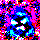

In [46]:
img_arr = np.reshape(l0a.value, IMG_SHAPE).astype(np.uint8)
display(PIL.Image.fromarray(img_arr))

In [28]:
print(np.min(l1z.value), np.max(l1z.value))

-7151.369775578802 12349.772123873583
